# NB05: psRCH2 Counter Ion Comparison — CuCl₂ vs CuSO₄

**Goal**: Direct within-organism comparison of copper delivered as chloride vs sulfate.
psRCH2 is the only organism tested with the same metal using different counter ions.

**Caveat**: The CuCl₂ experiments are anaerobic (lactate-nitrate) while CuSO₄ experiments
are aerobic (lactate). The confound is severe — aerobic/anaerobic differences dominate
many gene fitness values independent of copper. We include within-condition replicate
correlations as a positive control to quantify the baseline.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pathlib import Path

PROJ = Path('..')
REPO = PROJ / '..'
MAT_DIR = REPO / 'fitness_modules' / 'data' / 'matrices'
EXP_DIR = REPO / 'fitness_modules' / 'data' / 'annotations'
DATA_OUT = PROJ / 'data'
FIG_OUT = PROJ / 'figures'

# Load psRCH2 data
mat = pd.read_csv(MAT_DIR / 'psRCH2_fitness_matrix.csv', index_col=0)
exps = pd.read_csv(EXP_DIR / 'psRCH2_experiments.csv')
metal_exps = pd.read_csv(REPO / 'metal_fitness_atlas' / 'data' / 'metal_experiments.csv')
psrch2_cu = metal_exps[(metal_exps['orgId'] == 'psRCH2') & (metal_exps['metal_element'] == 'Copper')]

print(f'psRCH2 matrix: {mat.shape[0]} genes × {mat.shape[1]} experiments')
print(f'\nCopper experiments:')
for _, row in psrch2_cu.iterrows():
    in_mat = '✓' if row['expName'] in mat.columns else '✗'
    print(f'  [{in_mat}] {row["expName"]} | {row["expDesc"]} | {row["condition_1"]}')

psRCH2 matrix: 3349 genes × 350 experiments

Copper experiments:
  [✓] set16IT060 | Lactate-nitrate; anaerobic; copper stress sample1 | copper (II) chloride dihydrate
  [✓] set16IT061 | Lactate-nitrate; anaerobic; copper stress sample2 | copper (II) chloride dihydrate
  [✓] set16IT062 | Lactate-nitrate; anaerobic; copper stress sample3 | copper (II) chloride dihydrate
  [✓] set16IT075 | Lactate-nitrite; anaerobic; with copper; sample1 | Sodium nitrite
  [✓] set16IT076 | Lactate-nitrite; anaerobic; with copper; sample2 | Sodium nitrite
  [✓] set16IT077 | Lactate-nitrite; anaerobic; with copper; sample3 | Sodium nitrite
  [✓] set16IT081 | Lactate-nitrite with YE; anaerobic; with copper; sample1 | Sodium nitrite
  [✓] set16IT082 | Lactate-nitrite with YE; anaerobic; with copper; sample2 | Sodium nitrite
  [✓] set16IT083 | Lactate-nitrite with YE; anaerobic; with copper; sample3 | Sodium nitrite
  [✓] set16IT087 | Lactate; aerobic; with copper, sample1 | Copper (II) sulfate pentahydrate
  

In [2]:
# Separate CuCl2 and CuSO4 experiments
cucl2_exps = psrch2_cu[psrch2_cu['condition_1'].str.contains('chloride', case=False, na=False)]
cuso4_exps = psrch2_cu[psrch2_cu['condition_1'].str.contains('sulfate', case=False, na=False)]

cucl2_cols = [c for c in cucl2_exps['expName'] if c in mat.columns]
cuso4_cols = [c for c in cuso4_exps['expName'] if c in mat.columns]

print(f'CuCl₂ experiments in matrix: {cucl2_cols}')
print(f'CuSO₄ experiments in matrix: {cuso4_cols}')

if cucl2_cols and cuso4_cols:
    # Mean fitness profiles
    cucl2_profile = mat[cucl2_cols].mean(axis=1)
    cuso4_profile = mat[cuso4_cols].mean(axis=1)
    
    # Correlation between CuCl2 and CuSO4
    mask = cucl2_profile.notna() & cuso4_profile.notna()
    r_cross, p_cross = stats.pearsonr(cucl2_profile[mask], cuso4_profile[mask])
    print(f'\nCuCl₂ vs CuSO₄ Pearson r = {r_cross:.3f} (p = {p_cross:.2e}, n = {mask.sum()})')
    
    # Within-CuCl2 replicate correlations (positive control)
    if len(cucl2_cols) >= 2:
        within_r = []
        for i in range(len(cucl2_cols)):
            for j in range(i+1, len(cucl2_cols)):
                r_ij, _ = stats.pearsonr(
                    mat[cucl2_cols[i]].dropna(),
                    mat[cucl2_cols[j]].dropna()
                )
                within_r.append(r_ij)
        print(f'Within-CuCl₂ replicate correlations: {[f"{r:.3f}" for r in within_r]}')
        print(f'  Mean within-CuCl₂ r = {np.mean(within_r):.3f}')
    
    if len(cuso4_cols) >= 2:
        within_r_so4 = []
        for i in range(len(cuso4_cols)):
            for j in range(i+1, len(cuso4_cols)):
                r_ij, _ = stats.pearsonr(
                    mat[cuso4_cols[i]].dropna(),
                    mat[cuso4_cols[j]].dropna()
                )
                within_r_so4.append(r_ij)
        print(f'Within-CuSO₄ replicate correlations: {[f"{r:.3f}" for r in within_r_so4]}')
        print(f'  Mean within-CuSO₄ r = {np.mean(within_r_so4):.3f}')
    
    # Also get NaCl correlation for psRCH2
    nacl_exps_psrch2 = pd.read_csv(DATA_OUT / 'nacl_experiments.csv')
    nacl_psrch2 = nacl_exps_psrch2[
        (nacl_exps_psrch2['orgId'] == 'psRCH2') & (nacl_exps_psrch2['salt_type'] == 'NaCl')
    ]
    nacl_cols = [c for c in nacl_psrch2['expName'] if c in mat.columns]
    if nacl_cols:
        nacl_profile = mat[nacl_cols].mean(axis=1)
        r_cucl2_nacl, _ = stats.pearsonr(cucl2_profile[mask], nacl_profile[mask])
        r_cuso4_nacl, _ = stats.pearsonr(cuso4_profile[mask], nacl_profile[mask])
        print(f'\nCuCl₂ vs NaCl r = {r_cucl2_nacl:.3f}')
        print(f'CuSO₄ vs NaCl r = {r_cuso4_nacl:.3f}')
else:
    print('Not enough experiments in matrix for comparison')

CuCl₂ experiments in matrix: ['set16IT060', 'set16IT061', 'set16IT062']
CuSO₄ experiments in matrix: ['set16IT087', 'set16IT088', 'set16IT089']

CuCl₂ vs CuSO₄ Pearson r = 0.439 (p = 1.64e-157, n = 3349)
Within-CuCl₂ replicate correlations: ['0.711', '0.721', '0.729']
  Mean within-CuCl₂ r = 0.720
Within-CuSO₄ replicate correlations: ['0.854', '0.859', '0.864']
  Mean within-CuSO₄ r = 0.859

CuCl₂ vs NaCl r = 0.212
CuSO₄ vs NaCl r = 0.450


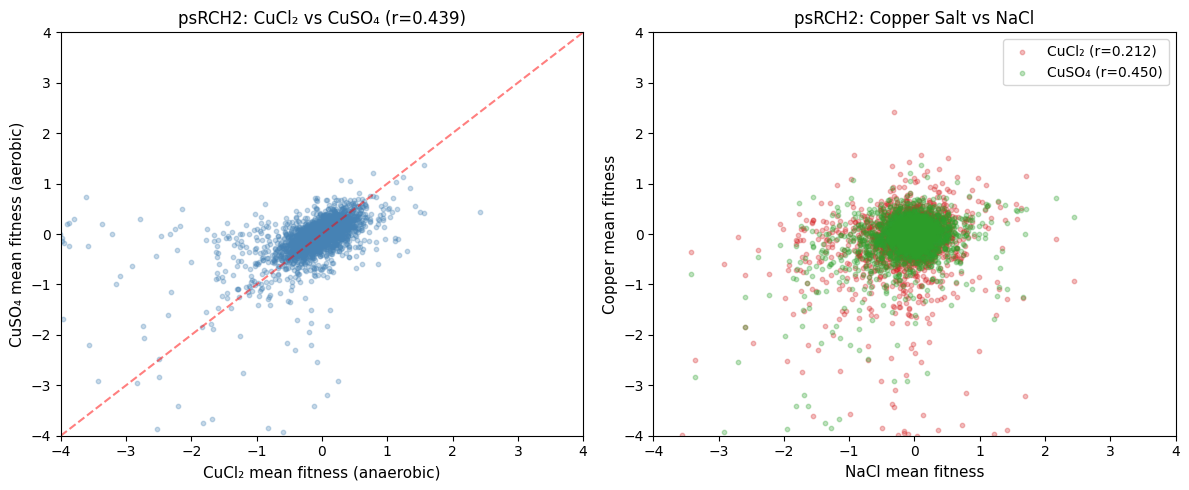

Saved to figures/psrch2_copper_comparison.png


In [3]:
# Figure: CuCl2 vs CuSO4 scatter
if cucl2_cols and cuso4_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Panel A: CuCl2 vs CuSO4
    ax = axes[0]
    ax.scatter(cucl2_profile, cuso4_profile, alpha=0.3, s=10, c='steelblue')
    ax.set_xlabel('CuCl₂ mean fitness (anaerobic)', fontsize=11)
    ax.set_ylabel('CuSO₄ mean fitness (aerobic)', fontsize=11)
    ax.set_title(f'psRCH2: CuCl₂ vs CuSO₄ (r={r_cross:.3f})', fontsize=12)
    ax.plot([-4, 4], [-4, 4], 'r--', alpha=0.5)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    
    # Panel B: Both vs NaCl
    if nacl_cols:
        ax = axes[1]
        ax.scatter(nacl_profile, cucl2_profile, alpha=0.3, s=10, c='#d62728', label=f'CuCl₂ (r={r_cucl2_nacl:.3f})')
        ax.scatter(nacl_profile, cuso4_profile, alpha=0.3, s=10, c='#2ca02c', label=f'CuSO₄ (r={r_cuso4_nacl:.3f})')
        ax.set_xlabel('NaCl mean fitness', fontsize=11)
        ax.set_ylabel('Copper mean fitness', fontsize=11)
        ax.set_title('psRCH2: Copper Salt vs NaCl', fontsize=12)
        ax.legend(fontsize=10)
        ax.set_xlim(-4, 4)
        ax.set_ylim(-4, 4)
    
    plt.tight_layout()
    fig.savefig(FIG_OUT / 'psrch2_copper_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved to figures/psrch2_copper_comparison.png')

## Summary

The psRCH2 CuCl₂ vs CuSO₄ comparison is confounded by aerobic/anaerobic growth conditions.
The cross-salt correlation and NaCl comparisons provide context but cannot definitively
isolate the counter ion effect from the growth condition effect.